# Green AI : Small collection of green techniques that can be used on tabular data

In [1]:
import green_ai
import green_ai.models
import green_ai.utils
import green_ai.experimentation
import green_ai.datasets

import torch
from torch.utils.data import TensorDataset, DataLoader

import sklearn
import sklearn.metrics

import pandas as pd
import numpy as np

import dill
from typing import List, Tuple, Dict, Any, Union, Optional

import copy
import warnings

warnings.filterwarnings("ignore")

SEED = 282
np.random.seed(SEED)
torch.manual_seed(SEED)

# The dataset : spotify song with multiple features like acousticness etc.. the goal is to predict 'popularity'

In [2]:
spotify_songs = pd.read_csv(
    "/Users/camille.hascoet/Documents/greenai/src/hale/sandbox/data/tracks.csv"
)
spotify_songs.head()
# number of rows
dataset_length = len(spotify_songs)
print(dataset_length)

586672


In [3]:
spotify_songs.sort_values(by="popularity", ascending=False).head(5)

id                                    name  \
93802  4iJyoBOLtHqaGxP12qzhQI  Peaches (feat. Daniel Caesar & Giveon)   
93803  7lPN2DXiMsVn7XUKtOW1CS                         drivers license   
93804  3Ofmpyhv5UAQ70mENzB277                  Astronaut In The Ocean   
92810  5QO79kh1waicV47BqGRL3g                         Save Your Tears   
92811  6tDDoYIxWvMLTdKpjFkc1B                               telepatía   

       popularity  duration_ms  explicit  \
93802         100       198082         1   
93803          99       242014         1   
93804          98       132780         0   
92810          97       215627         1   
92811          97       160191         0   

                                            artists  \
93802  ['Justin Bieber', 'Daniel Caesar', 'Giveon']   
93803                            ['Olivia Rodrigo']   
93804                               ['Masked Wolf']   
92810                                ['The Weeknd']   
92811                                ['Kali Uchis']   

                                              id_artists release_date  \
93802  ['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...   2021-03-19   
93803                         ['1McMsnEElThX1knmY4oliG']   2021-01-08   
93804                         ['1uU7g3DNSbsu0QjSEqZtEd']   2021-01-06   
92810                         ['1Xyo4u8uXC1ZmMpatF05PJ']   2020-03-20   
92811                         ['1U1el3k54VvEUzo3ybLPlM']   2020-12-04   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
93802         0.677   0.696    0    -6.181     1       0.1190        0.3210   
93803         0.585   0.436   10    -8.761     1       0.0601        0.7210   
93804         0.778   0.695    4    -6.865     0       0.0913        0.1750   
92810         0.680   0.826    0    -5.487     1       0.0309        0.0212   
92811         0.653   0.524   11    -9.016     0       0.0502        0.1120   

       instrumentalness  liveness  valence    tempo  time_signature  
93802          0.000000     0.420    0.464   90.030               4  
93803          0.000013     0.105    0.132  143.874               4  
93804          0.000000     0.150    0.472  149.996               4  
92810          0.000012     0.543    0.644  118.051               4  
92811          0.000000     0.203    0.553   83.970               4

In [4]:
# extract the features
X = spotify_songs.drop(
    ["popularity", "id", "name", "artists", "id_artists", "release_date"], axis=1
)
y = spotify_songs["popularity"]

In [5]:
correlation = X.corrwith(y)
correlation = correlation.sort_values(ascending=False)
correlation

loudness            0.327028
energy              0.302315
explicit            0.211758
danceability        0.187000
time_signature      0.086759
tempo               0.071364
duration_ms         0.027681
key                 0.015299
valence             0.004643
mode               -0.033655
speechiness        -0.047357
liveness           -0.048740
instrumentalness   -0.236487
acousticness       -0.370882
dtype: float64

### On retire les colonnes non exhaustives

In [6]:
X_drop = X.drop(
    ["mode", "valence", "key", "duration_ms", "speechiness", "liveness"], axis=1
)

### On retire les colonnes 'trop' corrélées' pour rendre la tâche plus dure

In [7]:
X.drop = X.drop(
    [
        "loudness",
        "energy",
        "explicit",
        "acousticness",
        "instrumentalness",
        "danceability",
    ],
    axis=1,
)

### On prend seulement un subset car trop long sinon, on vérifie son intégrité en comparant la moyenne de la target par rapport à celle de base

In [8]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_drop)
y_scaled = y.values.reshape(-1, 1) / 100

print(y_scaled.mean())

# shuffle and take 20000 samples
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_scaled, y_scaled, random_state=SEED)

X_train = X_shuffled[:20000]
y_train = y_shuffled[:20000]

X_test = X_shuffled[20000:25000]
y_test = y_shuffled[20000:25000]

print(y_train.mean(), y_test.mean())

input_size = X_train.shape[1]
hidden_size = 200
output_size = 1

0.2757005277224752
0.274065 0.27327399999999996


### Définition de nos trainloader, testloader, models, optimizers etc..

In [9]:
train_loader, test_loader = green_ai.datasets.make_train_test_loader(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size=64
)

In [10]:
base_model = green_ai.models.torch_small_NN(input_size, hidden_size, output_size)

qat_model = green_ai.models.torch_QATModel(base_model)

criterion = torch.nn.L1Loss()

base_optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

qat_optimizer = torch.optim.Adam(qat_model.parameters(), lr=0.001)

In [11]:
log_file = "logs/tabular_data.csv"
base_qat_log_id = "base__qat"
EPOCHS = 10

### Class experimentation & run

In [12]:
try:
    with open("experiments/experiment_qat.pkl", "rb") as f:
        experiment_qat = dill.load(f)
except FileNotFoundError:
    experiment_qat = green_ai.experimentation.torch_Experimentation(
        models=[base_model, qat_model],
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=criterion,
        optimizers=[base_optimizer, qat_optimizer],
        metric_fn=sklearn.metrics.r2_score,
        log_file=log_file,
        log_id=base_qat_log_id,
        random_seed=SEED,
        model_names=["base", "qat"],
        epochs=EPOCHS,
        validation_set=True,
        validation_size=0.15,
        patience=3,
    )
    experiment_qat.run_experiment()
    with open("experiments/experiment_qat.pkl", "wb") as f:
        dill.dump(experiment_qat, f)

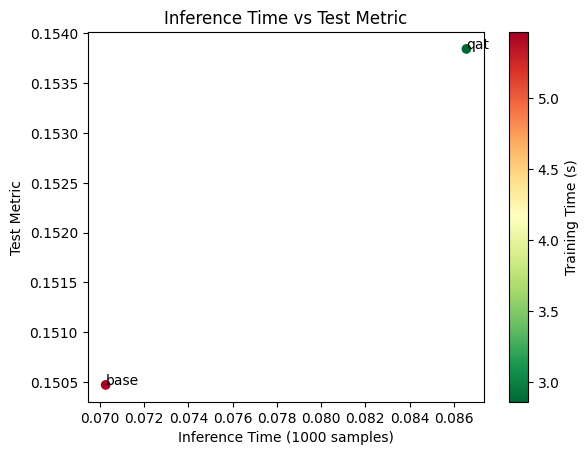

In [13]:
experiment_qat.plot_inference_vs_score()

In [14]:
experiment_qat.print_results()

  Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0  base        5.463449               0.000105   0.131574     0.150470   
1   qat        2.863955               0.000167   0.132634     0.153845   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.070254                   0.000013  
1                       0.086573                   0.000022  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0  base        5.463449               0.000105   0.131574     0.150470   
1   qat        2.863955               0.000167   0.132634     0.153845   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.070254                   0.000013  
1                       0.086573                   0.000022

In [15]:
base_model, qat_model = experiment_qat.get_models()

print(green_ai.utils.get_torch_model_size(base_model))
print(green_ai.utils.get_torch_model_size(qat_model))

0.009968
0.010596


In [16]:
print(base_model)

torch_small_NN(
  (hidden): Linear(in_features=8, out_features=200, bias=True)
  (hidden_activation): ReLU()
  (output): Linear(in_features=200, out_features=1, bias=True)
  (output_activation): Identity()
)


In [17]:
hidden_sizes = [5000, 3000, 1000]
log_file_nn = "logs/tabular_data_nn.csv"

base_nn = green_ai.models.torch_NN(
    input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size
)

qat_nn = green_ai.models.torch_QATModel(base_nn)

base_optimizer = torch.optim.Adam(base_nn.parameters(), lr=0.001)

qat_optimizer = torch.optim.Adam(qat_nn.parameters(), lr=0.001)

In [18]:
try:
    with open("experiments/experiment_qat_nn.pkl", "rb") as f:
        experiment_qat_nn = dill.load(f)
except FileNotFoundError:
    experiment_qat_nn = green_ai.experimentation.torch_Experimentation(
        models=[base_nn, qat_nn],
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=criterion,
        optimizers=[base_optimizer, qat_optimizer],
        metric_fn=sklearn.metrics.r2_score,
        log_file=log_file_nn,
        log_id=base_qat_log_id,
        random_seed=SEED,
        model_names=["base", "qat"],
        epochs=EPOCHS,
        validation_set=True,
        validation_size=0.15,
        patience=3,
    )
    experiment_qat_nn.run_experiment()
    with open("experiments/experiment_qat_nn.pkl", "wb") as f:
        dill.dump(experiment_qat_nn, f)

Training models...
Training base...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Epoch 3/10, Loss: 0.0020474016641577083


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned

Epoch 6/10, Loss: 0.002006248193482558


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCo

Epoch 9/10, Loss: 0.0019846094846725465


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


base trained successfully
Training qat...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.


Epoch 3/10, Loss: 0.0020315360724925996


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

Epoch 6/10, Loss: 0.0020084809040029844


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region

Early stopping
qat trained successfully
Testing models...
Testing base...
base tested successfully
Testing qat...
qat tested successfully
Timing models...
Timing base...


OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
OMP: Warning #191: Forking a process while a parallel region is active is potentially unsafe.
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


base timed successfully
Timing qat...
qat timed successfully


In [28]:
experiment_qat_nn.print_results()

  Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0  base       46.378187               0.027091   0.127468     0.200332   
1   qat       44.775758               0.026299   0.138340     0.039540   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.412456                   0.002360  
1                       0.295263                   0.000755  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0  base       46.378187               0.027091   0.127468     0.200332   
1   qat       44.775758               0.026299   0.138340     0.039540   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.412456                   0.002360  
1                       0.295263                   0.000755

In [29]:
base_nn, qat_nn = experiment_qat_nn.get_models()

In [30]:
print(green_ai.utils.get_torch_model_size(base_nn))
print(green_ai.utils.get_torch_model_size(qat_nn))

72.20296
18.228816


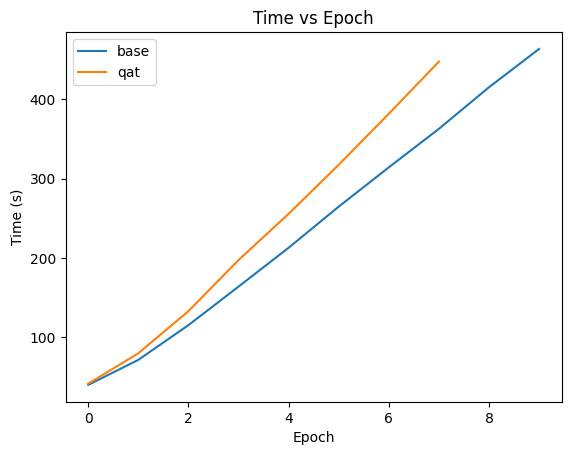

In [22]:
experiment_qat_nn.plot_time(option="time")

# KNOWLEDGE DISTILLATION

In [23]:
teacher = green_ai.models.torch_NN(
    input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size
)

student = green_ai.models.torch_small_NN(input_size, hidden_size, output_size)

student_kd = green_ai.models.Student(teacher=teacher, student=copy.deepcopy(student))
criterion = torch.nn.L1Loss()

teacher_optimizer = torch.optim.Adam(teacher.parameters(), lr=0.001)

student_optimizer = torch.optim.Adam(student.parameters(), lr=0.001)

student_kd_optimizer = torch.optim.Adam(student_kd.parameters(), lr=0.001)

log_file_kd = "logs/tabular_data_kd.csv"

In [24]:
try:

    with open("experiments/experiment_kd.pkl", "rb") as f:
        experiment_kd = dill.load(f)

except FileNotFoundError:

    experiment_kd = green_ai.experimentation.torch_Experimentation(
        models=[teacher, student, student_kd],
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=criterion,
        optimizers=[teacher_optimizer, student_optimizer, student_kd_optimizer],
        metric_fn=sklearn.metrics.r2_score,
        log_file=log_file_kd,
        log_id="kd",
        random_seed=SEED,
        epochs=EPOCHS,
        model_names=["teacher", "student", "student_kd"],
        validation_set=True,
        validation_size=0.15,
        patience=3,
    )
    experiment_kd.run_experiment()
    with open("experiments/experiment_kd.pkl", "wb") as f:
        dill.dump(experiment_kd, f)

In [25]:
results = experiment_kd.print_results()

        Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss  Test Metric  \
0     teacher       31.583753               0.009817   0.129107     0.184386   
1     student        5.352224               0.000149   0.130218     0.179512   
2  student_kd       38.188290               0.010521   0.130697     0.168201   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.277047                   0.000205  
1                       0.069521                   0.000010  
2                       0.073275                   0.000020  


In [26]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

r2_score = sklearn.metrics.r2_score(y_test, y_pred)
loss = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print(r2_score, loss)

0.1790521901412544 0.1345611421117765


In [27]:
teacher, student, student_kd = copy.deepcopy(experiment_kd.get_models())

## #TODO find more complex dataset